In [110]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import talib as ta
import math
import matplotlib.pyplot as plt
from datetime import datetime

In [111]:
start = "2018-01-01"
end = "2022-06-27"

In [112]:
assets = ["FB", "AMZN", "AAPL", "NFLX", "GOOG"]

In [113]:
for asset in assets:
    exec("{} = web.DataReader(asset, data_source='yahoo', start = start, end = end)".format(asset))

In [114]:
asset_list = [FB, AMZN, AAPL, NFLX, GOOG]

In [115]:
#Calculating the technical indicators with talib using the functions for momentum indicators
def indikator(asset):
    asset["RSI"] = ta.RSI(asset["Close"], timeperiod = 14)
    asset["ROC"] = ta.ROC(asset["Close"], timeperiod = 10)
    asset["%R"] = ta.WILLR(asset["High"], asset["Low"], asset["Close"], timeperiod = 14)
    asset["OBV"] = ta.OBV(asset["Close"], asset["Volume"])
    asset["MACD"], asset["MACD_SIGNAL"], asset["MACD_HIST"] = ta.MACD(asset["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    
    asset["Prediction"] = np.where(asset["Close"].shift(-5) > asset["Close"], 1, -1)

In [116]:
for asset in asset_list:
    indikator(asset)

In [117]:
df = FB.append((AMZN, AAPL, NFLX, GOOG))

C:\Users\Bene\AppData\Local\Temp\ipykernel_27340\3247942324.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = FB.append((AMZN, AAPL, NFLX, GOOG))


In [118]:
df.dropna(inplace = True)

In [119]:
#Splitting the data into X and y variables and perform a train test split
from sklearn.model_selection import train_test_split

X = df[["RSI", "ROC", "OBV","%R", "MACD", "MACD_SIGNAL", "MACD_HIST"]]
y = df[["Prediction"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, train_size = 0.8, test_size=0.2)

In [120]:
#Creating the model with the Random Forest classifier, choosing the gini criterion 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators = 1000, oob_score = True, criterion = "gini", random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)



C:\Users\Bene\AppData\Local\Temp\ipykernel_27340\1776172524.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [121]:
print("Correct prediction in %: ", accuracy_score(y_test, y_pred, normalize= True)*100)

Correct prediction in %:  67.75244299674267


In [122]:
#Getting the NVIDA company for the timeperiod 2020 to 2021
test_stock = web.DataReader("WMT", data_source="yahoo", start="2020-01-01", end = "2021-02-14")

#Performing the indicator function on the new data
indikator(test_stock)

#Dropping all NaN values so the model can make predictions on the new data
test_stock.dropna(inplace=True)

In [123]:
test_stock["predicted"] = model.predict(test_stock[["RSI", "ROC", "OBV","%R", "MACD", "MACD_SIGNAL", "MACD_HIST"]])

In [124]:
test_stock.head()

,High,Low,Open,Close,Volume,Adj Close,RSI,ROC,%R,OBV,MACD,MACD_SIGNAL,MACD_HIST,Prediction,predicted
Date,,,,,,,,,,,,,,,
2020-02-20,118.110001,116.860001,117.209999,117.690002,5022900.0,113.095505,52.279714,0.753364,-37.355309,11064200.0,0.350442,-0.098357,0.448799,-1,1
2020-02-21,118.750000,117.309998,117.440002,118.580002,6242100.0,113.950752,55.742535,1.951685,-23.418726,17306300.0,0.449207,0.011156,0.438051,-1,1
2020-02-24,118.459999,115.949997,117.459999,116.320000,6616000.0,111.778984,46.512550,-0.111634,-65.880234,10690300.0,0.341184,0.077161,0.264022,-1,1
2020-02-25,117.070000,114.050003,116.349998,114.389999,7764300.0,109.924339,40.365610,-0.746204,-94.237344,2926000.0,0.098701,0.081469,0.017232,-1,1
2020-02-26,115.169998,113.650002,114.699997,113.779999,6673300.0,109.338135,38.628014,-1.403815,-97.936550,-3747300.0,-0.141064,0.036963,-0.178027,1,1


In [125]:
def buy_sell(asset):
    BuyPrice = []
    SellPrice = []
    flag = -1
    counter = 0
    n=5
    
    for i in range(len(asset)):
        if asset["predicted"][i] == 1 and counter == 0:
            if flag != 1:
                BuyPrice.append(asset["Adj Close"][i])
                SellPrice.append(np.nan)
                flag = 1
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        elif asset["predicted"][i] == -1 and counter ==0:
            if flag !=0:
                BuyPrice.append(np.nan)
                SellPrice.append(asset["Adj Close"][i])
                flag = 0
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        else:
            BuyPrice.append(np.nan)
            SellPrice.append(np.nan)
            
        counter +=1
        if counter ==n:
            counter = 0
            
    return (BuyPrice, SellPrice)

In [126]:
buysell = buy_sell(test_stock)

In [127]:
test_stock["Buy"] = buysell[0]
test_stock["Sell"] = buysell[1]

In [128]:
test_stock

,High,Low,Open,Close,Volume,Adj Close,RSI,ROC,%R,OBV,MACD,MACD_SIGNAL,MACD_HIST,Prediction,predicted,Buy,Sell
Date,,,,,,,,,,,,,,,,,
2020-02-20,118.110001,116.860001,117.209999,117.690002,5022900.0,113.095505,52.279714,0.753364,-37.355309,11064200.0,0.350442,-0.098357,0.448799,-1,1,113.095505,NaN
2020-02-21,118.750000,117.309998,117.440002,118.580002,6242100.0,113.950752,55.742535,1.951685,-23.418726,17306300.0,0.449207,0.011156,0.438051,-1,1,NaN,NaN
2020-02-24,118.459999,115.949997,117.459999,116.320000,6616000.0,111.778984,46.512550,-0.111634,-65.880234,10690300.0,0.341184,0.077161,0.264022,-1,1,NaN,NaN
2020-02-25,117.070000,114.050003,116.349998,114.389999,7764300.0,109.924339,40.365610,-0.746204,-94.237344,2926000.0,0.098701,0.081469,0.017232,-1,1,NaN,NaN
2020-02-26,115.169998,113.650002,114.699997,113.779999,6673300.0,109.338135,38.628014,-1.403815,-97.936550,-3747300.0,-0.141064,0.036963,-0.178027,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,145.580002,144.460007,144.809998,145.029999,5275100.0,141.694672,51.999987,-0.800272,-32.641320,-131043000.0,-0.870416,-0.924994,0.054578,-1,1,NaN,NaN
2021-02-09,146.320007,144.580002,144.580002,145.830002,5302300.0,142.476288,54.266403,-1.138901,-23.414062,-125740700.0,-0.617390,-0.863473,0.246083,-1,1,NaN,NaN
2021-02-10,145.899994,143.539993,145.830002,144.130005,6192300.0,140.815399,48.974526,0.201619,-43.021874,-131933000.0,-0.547727,-0.800324,0.252597,-1,1,NaN,NaN


In [129]:
#Replacing the first Sell signal by a NaN value
test_stock["Sell"][0] = np.nan

C:\Users\Bene\AppData\Local\Temp\ipykernel_27340\3999435319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_stock["Sell"][0] = np.nan


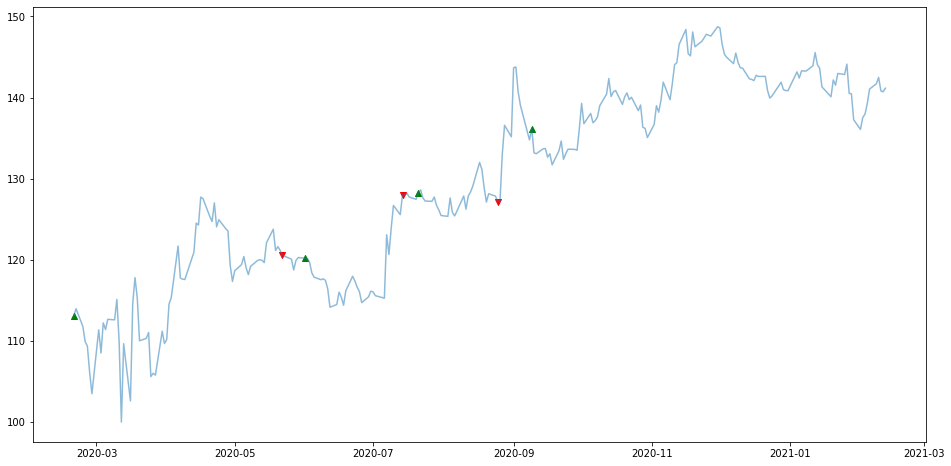

In [130]:
#Plotting our Signals on our time period
plt.figure(figsize=(16,8))
plt.scatter(test_stock.index, test_stock["Buy"], color = "green", label = "Buy", marker = "^", alpha=1)
plt.scatter(test_stock.index, test_stock["Sell"], color = "red", label = "Sell", marker = "v", alpha=1)
plt.plot(test_stock.index, test_stock["Adj Close"], alpha = 0.5)
plt.show()

In [131]:
def performance(data):
    performance = [1000000]
    num_stocks = 0
    for i in range(len(data)):
        if math.isnan(data["Buy"][i]) == False:
            num_stocks = performance[i]/data["Adj Close"][i]
            performance.append(num_stocks*data["Adj Close"][i])
        elif math.isnan(data["Sell"][i]) == False:
            cash = num_stocks * data["Adj Close"][i]
            performance.append(cash)
        else: 
            performance.append(performance[i])
            
    return performance

In [132]:
test_stock_performance = performance(test_stock)

In [133]:
# test_stock_performance

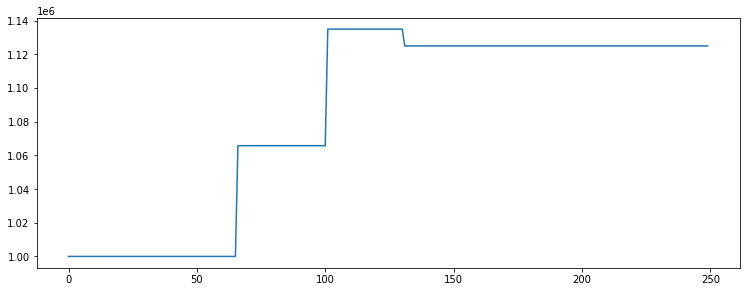

In [134]:
plt.figure(figsize= (12.6, 4.6))
plt.plot(test_stock_performance)